In [3]:
import numpy as np
import re
import torch
import torch.autograd as autograd  # computation graph
from SF_PINN.aux_functions import (load_checkpoint, FCN,
                                   get_measurement_vectors, maxabs_normalize_rirs,
                                   plot_sf, plot_sf_quiver, standardize_rirs,
                                   config_from_yaml)
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tfnp = lambda x: torch.from_numpy(x).float().to(device)
torch.manual_seed(0)
np.random.seed(0)
import os

### Functions

In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text


def plot_settings():
    width = 6.694

    tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 13,
        "font.size": 13,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    }

    mpl.rcParams.update(tex_fonts)
    mpl.rcParams['mathtext.fontset'] = 'stix'
    mpl.rcParams['font.family'] = 'STIXGeneral'
    mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    # plt.rcParams["figure.figsize"] = (6.694, 5)
    # plt.rcParams['figure.constrained_layout.use'] = True
    return width


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [atoi(c) for c in re.split(r'(\d+)', text)]


def correct_rir_alignment(rir, lag, forward=True):
    if forward:
        return np.pad(rir, (lag, 0), 'constant')[:-lag]
    else:
        return np.pad(rir[lag:], (0, lag), 'constant')


def construct_input_vec(x, y, t):
    collocation = []
    for i in range(len(t)):
        tt = np.repeat(t[i], len(x))
        collocation.append(np.stack([x, y, tt], axis=0))
    return np.array(collocation)


def net_inference(net, x, y, t, fs=8e3, c=343., t_init=None, t_trunc=None):
    if t_init is not None:
        init = int(fs * (t_init - 0.003))  # 3 ms because that's how it was trained
    else:
        init = 0
    if t_trunc is not None:
        trunc = int(fs * (t_trunc - 0.003)) + 1  # 3 ms because that's how it was trained
    else:
        trunc = None
    coll = construct_input_vec(x, y, c * t)
    netout = []
    for i, set in enumerate(tqdm(coll)):
        out = net.dnn(tfnp(set.T).unsqueeze(-1))
        netout.append(out.squeeze(-1).detach().cpu().numpy())
    return np.array(netout).T[:, init:trunc]


def particle_velocity_inference(net, x, y, t, fs=8e3, c=343., t_init=None, t_trunc=None):
    rho = 1.204
    if t_init is not None:
        init = int(fs * (t_init - 0.003))  # 3 ms because that's how it was trained
    else:
        init = 0
    if t_trunc is not None:
        trunc = int(fs * (t_trunc - 0.003)) + 1  # 3 ms because that's how it was trained
    else:
        trunc = None
    t = t[init:trunc]
    # coll = construct_input_vec(x, y, c * t[init:trunc])
    dt = t[1] - t[0]
    # add extra point to t
    time = np.append(t, t[-1] + dt)
    vel = []
    # use tqdm to show progress
    for i in tqdm(range(len(time) - 1)):
        # interpolate between time points
        t_interp = np.linspace(time[i], time[i + 1], 10)
        # construct input vector
        coll = construct_input_vec(x, y, c * t_interp)
        # convert to torch tensor
        net_in = tfnp(coll).permute(0, 2, 1)
        # initilaize dvdr
        dvdrs = []
        for input_coord in net_in:
            input_coord.requires_grad = True
            input_coord = input_coord.unsqueeze(-1)
            out = net.dnn(input_coord)  # (Nx x Ny´, 1)
            dpdr = autograd.grad(out.view(-1, 1), input_coord, torch.ones([input_coord.shape[0], 1]).to(device),
                                 create_graph=True)[0]
            # only append x,y components
            dvdr = dpdr.squeeze(-1)[..., :2]
            dvdrs.append(dvdr.detach().cpu().numpy())
        # integrate velocity
        vel.append(1 / rho * np.trapz(np.array(dvdrs), x=t_interp, axis=0))

    return np.array(vel).T


def plot_rir(y_truth, y_pred, label=None, t_intervals=None, color=None,
             ax=None, fs=8000):
    if t_intervals is None:
        t_intervals = [.01, .2]
    # fig, ax = plt.subplots(1, 1, figsize=(width, width/4))
    if color is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        color = colors[0]
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = 'prediction'

    t = np.linspace(0, len(y_truth) / fs, len(y_truth))
    t_ind = np.argwhere((t > t_intervals[0]) & (t < t_intervals[1]))[:, 0]
    ax.plot(t[t_ind], y_truth[t_ind], linewidth=1, color='k', label='Ground truth')
    ax.plot(t[t_ind], y_pred[t_ind], linewidth=0.8, color=color, label=label)
    ax.set_ylim([np.min(y_truth) - .1 * np.max(y_truth), np.max(y_truth) + .15 * np.max(y_truth)])
    # ax.set_ylim([np.min(y_truth) , np.max(y_truth)])
    ax.set_xlim([t_intervals[0] - 0.5 * t_intervals[0], t_intervals[1]])
    # ax.annotate('Corr. Coeff.: {:.3f}'.format(np.corrcoef(y_truth[:int(.5 * fs)],
    #                                                       y_pred[:int(.5 * fs)])[0, 1]),
    #             xy=(.9 * t[t_ind].max(), 1.05 * np.max(y_truth[t_ind])))
    # ax.grid(linestyle=':', which='both', color='k')
    ax.grid(linestyle=':', which='both', color='k', alpha=0.3)

    return ax


def latex_colum_width_to_figsize(width, fraction=1, subplots=(1, 1)):
    """Convert a latex columnwidth to a figure width in inches.

    Parameters
    ----------
    width : float
        Latex columnwidth in pt
    fraction : float, optional
        Fraction of the width which you wish the figure to occupy
    subplots : tuple, optional
        Number of rows and columns of subplots

    Returns
    -------
    fig_dim : tuple
        Dimensions of figure in inches
    """
    fig_width_pt = width * fraction
    inches_per_pt = 1 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5) - 1) / 2  # Golden ratio to set aesthetic figure height
    fig_width_in = fig_width_pt * inches_per_pt  # Figure width in inches
    fig_height_in = fig_width_in * golden_mean * (subplots[0] / subplots[1])  # Figure height in inches
    fig_dim = (fig_width_in, fig_height_in)  # Dimensions of figure in inches
    return fig_dim


def plot_frf(y_truth, y_pred, label=None, color=None, ax=None,
             xscale='log', fs=8000):
    from matplotlib.ticker import FuncFormatter
    def kilos(x, pos):
        'The two args are the value and tick position'
        if x < 10:
            return None
        elif x == 100:
            return '%1.1fk' % (x * 1e-3)
        # elif x == 500:
        #     return '%1.1fk' % (x * 1e-3)
        elif x == 1000:
            return '%1dk' % (x * 1e-3)
        # elif x >= 1000:
        #     return '%1.1fk' % (x * 1e-3)

    def to_dB(x, norm=False):
        if norm:
            x = x / np.max(abs(x))

        return 20 * np.log10(abs(x))

    if color is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        color = colors[0]
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = 'prediction'
    freq = np.fft.rfftfreq(len(y_truth), d=1 / fs)
    freq_ind = np.argwhere(freq > 20)[:, 0]
    fr_truth = np.fft.rfft(y_truth)
    fr_pred = np.fft.rfft(y_pred)
    Y_rec = to_dB(fr_pred, norm=True)
    Y_truth = to_dB(fr_truth, norm=True)
    if xscale == 'log':
        ax.semilogx(freq[freq_ind], Y_truth[freq_ind], linewidth=1, color='k', label='Ground truth')
        ax.semilogx(freq[freq_ind], Y_rec[freq_ind], linewidth=0.8, color=color, label=label)
        formatter = FuncFormatter(kilos)
        ax.set_xlim(freq[freq_ind][0], fs / 2 + 1)

        ax.xaxis.set_minor_formatter(formatter)
        ax.xaxis.set_major_formatter(formatter)
    else:
        ax.plot(freq[freq_ind], Y_truth[freq_ind], linewidth=1, color='k', label='Ground truth')
        ax.plot(freq[freq_ind], Y_rec[freq_ind], linewidth=0.8, color=color, label=label)
        ax.set_xlim(freq[freq_ind][0], fs / 2 + 1)

    ax.set_yticks([-50, -25, 0])

    ax.set_ylim([-50, 5])
    ax.grid(linestyle=':', which='both', color='k', alpha=0.3)
    return ax


plot_settings()


6.694

### Configuration

In [8]:
config_file = os.path.join(os.getcwd(), 'config.yml')
hparams = config_from_yaml(config_file)
# Data path
filename = os.path.join('..', 'Data', 'SoundFieldControlPlanarDataset.h5')

### Load data

In [14]:
refdata, fs, grid, measureddata, grid_measured, c = get_measurement_vectors(filename,
                                                                            subsample_points=hparams.n_mics_per_dimension)
_, _, _, pref_sq, grid_sq, _ = get_measurement_vectors(filename,
                                                       subsample_points=None)
print('Data loaded from {}'.format(filename))
print('Number of microphones: {} with {} per dimension'.format(hparams.n_mics_per_dimension ** 2,
                                                               hparams.n_mics_per_dimension))
print('Room impulse response length: {} samples, sampled at fs = {}'.format(len(refdata[0, :]), fs))

Data loaded from ../Data/SoundFieldControlPlanarDataset.h5
Number of microphones: 100 with 10 per dimension
Room impulse response length: 4240 samples, sampled at fs = 8000


### Preprocess data

In [15]:
data = measureddata[:, int(0.003 * fs):int(hparams.rir_time * fs)]  # truncate
refdata = refdata[:, int(0.003 * fs):int(hparams.rir_time * fs)]  # truncate
pref_sq = pref_sq[:, int(0.003 * fs):int(hparams.rir_time * fs)]  # truncate
temp_data = refdata
if hparams.standardize_data:
    scaler = standardize_rirs(temp_data, device=device)
else:
    if hparams.map_input:
        l_inf_norm = 0.1
    else:
        l_inf_norm = 0.9
    if hparams.simulated_data:
        scaler = maxabs_normalize_rirs(temp_data, device=device, l_inf_norm=l_inf_norm)
    else:
        scaler = None

t_ind = np.arange(0, refdata.shape[-1])
t = np.linspace(0., refdata.shape[-1] / fs, refdata.shape[-1])
x_m = grid_measured[0]
y_m = grid_measured[1]
x_ref = grid[0]
y_ref = grid[1]

### Set domain boundaries

In [16]:
bounds = {
    'x': (1.1 * x_ref.min(), 1.1 * x_ref.max()),
    'y': (1.1 * y_ref.min(), 1.1 * y_ref.max()),
    't': (0, hparams.rir_time),
    'xdata': (x_ref.min(), x_ref.max()),
    'ydata': (y_ref.min(), y_ref.max())
}

# make expanded grid for estimation outside of the measured grid
x_extrap_ref = np.linspace(bounds['x'][0], bounds['x'][1], 35)
y_extrap_ref = np.linspace(bounds['y'][0], bounds['y'][1], 35)
x_extrap, y_extrap = np.meshgrid(x_extrap_ref, y_extrap_ref)
grid_extrap = np.stack([x_extrap.flatten(), y_extrap.flatten()], axis=-1).T
# create dense grid for plotting
x_dense_ref = np.linspace(x_ref.min(), x_ref.max(), 40)
y_dense_ref = np.linspace(y_ref.min(), y_ref.max(), 40)
x_dense, y_dense = np.meshgrid(x_dense_ref, y_dense_ref)
grid_dense = np.stack([x_dense.flatten(), y_dense.flatten()], axis=-1).T
# create sparse grid for plotting
x_sparse_ref = np.linspace(x_ref.min(), x_ref.max(), 10)
y_sparse_ref = np.linspace(y_ref.min(), y_ref.max(), 10)
x_sparse, y_sparse = np.meshgrid(x_sparse_ref, y_sparse_ref)
grid_sparse = np.stack([x_sparse.flatten(), y_sparse.flatten()], axis=-1).T


### PINN initialization

In [18]:
if hparams.adaptive_loss_weights:
    sigmas = []
    if hparams.lambda_data != 0.:
        sigmas.append(torch.tensor(2 / hparams.lambda_data, dtype=torch.float32, device=device, requires_grad=True))
    if hparams.lambda_pde != 0.:
        sigmas.append(torch.tensor(2 / hparams.lambda_pde, dtype=torch.float32, device=device, requires_grad=True))
    if hparams.lambda_bc != 0.:
        sigmas.append(torch.tensor(2 / hparams.lambda_bc, dtype=torch.float32, device=device, requires_grad=True))
    if hparams.lambda_ic != 0.:
        sigmas.append(torch.tensor(2 / hparams.lambda_ic, dtype=torch.float32, device=device, requires_grad=True))
    lambda_optimizer = torch.optim.Adam(sigmas, hparams.sigma_lr, betas=(0.9, 0.9),
                                        weight_decay=1e-5)
else:
    sigmas = [None]
# Get PINN network
PINN = FCN(n_hidden_layers=hparams.n_hidden_layers, bounds=bounds, device=device, siren=hparams.siren,
           lambda_data=hparams.lambda_data, lambda_pde=hparams.lambda_pde, lambda_bc=hparams.lambda_bc,
           c=c, lambda_ic=hparams.lambda_ic, loss_fn=hparams.loss_fn, output_scaler=scaler,
           fs=fs, map_input=hparams.map_input,
           activation=hparams.activation_fn, n_hidden_features=hparams.n_hidden_features,
           sigmas=sigmas, network_type=hparams.network_architecture)

print('Number of trainable parameters: {}'.format(sum(p.numel() for p in PINN.dnn.parameters() if p.requires_grad)))
print(PINN.dnn)

Number of trainable parameters: 531969
DNN(
  (activation): Identity()
  (net): MLPWithAttention(
    (U_encoder): Siren(
      (activation): Sine()
    )
    (V_encoder): Siren(
      (activation): Sine()
    )
    (activation): Identity()
    (layers): ModuleList(
      (0-2): 3 x Siren(
        (activation): Sine()
      )
    )
    (output_layer): Siren(
      (activation): Identity()
    )
  )
)


### Load model

In [24]:
checkpoint_dir = os.path.join(os.getcwd(), 'PINN_checkpoints')
cp_pinn = os.path.join(checkpoint_dir, 'PINN_00100000')
state_dict_pinn = load_checkpoint(cp_pinn, device)
PINN.dnn.load_state_dict(state_dict_pinn["net"])

Loading '/Users/xefonon/Documents/Repositories/SoundFieldPINN/SF_PINN/PINN_checkpoints/PINN_00100000'
Complete.


<All keys matched successfully>

### Net inference for extrapolation

In [25]:
t = np.linspace(0, hparams.rir_time, int(hparams.rir_time * fs))
p_net_extrap = net_inference(PINN, grid_extrap[0], grid_extrap[1], t, fs=fs, c=c)

100%|██████████| 800/800 [00:09<00:00, 85.96it/s]


### Net inference for interpolation

In [26]:
t = np.linspace(0, hparams.rir_time, int(hparams.rir_time * fs))
p_net = net_inference(PINN, grid[0], grid[1], t, fs=fs, c=c)
v_net = particle_velocity_inference(PINN, grid[0], grid[1], t, fs=fs, c=c)
p_net_dense = net_inference(PINN, grid_dense[0], grid_dense[1], t, fs=fs, c=c)
v_net_dense = particle_velocity_inference(PINN, grid_dense[0], grid_dense[1], t, fs=fs, c=c)
p_net_sparse = net_inference(PINN, grid_sparse[0], grid_sparse[1], t, fs=fs, c=c)
v_net_sparse = particle_velocity_inference(PINN, grid_sparse[0], grid_sparse[1], t, fs=fs, c=c)

100%|██████████| 800/800 [00:31<00:00, 25.13it/s]


## Instantaneous intensity inference

In [27]:
intensity_vector = np.multiply(p_net, v_net)
intensity_vector_dense = np.multiply(p_net_dense, v_net_dense)
intensity_vector_sparse = np.multiply(p_net_sparse, v_net_sparse)

## Pressure snapshots

In [32]:
# snapshot times
t_init = 0.0
t_trunc = 0.06
t_init_ind = np.argmin(np.abs(t - t_init))
t_trunc_ind = np.argmin(np.abs(t - t_trunc))
t_snapshots = [0.011, 0.0135, 0.021, 0.0395, 0.04]
# find closest time index
t_ind = [np.argmin(np.abs(t[t_init_ind:t_trunc_ind] - t_)) for t_ in t_snapshots]
# 
p_true = pref_sq[:, :int(hparams.rir_time * fs)]
p_meas = data[:, :int(hparams.rir_time * fs)]
p_net_norm = p_net_dense / np.max(np.abs(p_net_dense))
p_true_norm = p_true / np.max(np.abs(p_true))
p_meas_norm = p_meas / np.max(np.abs(p_meas))
clims = (p_net_norm[:, t_ind].min() / 1.4, p_net_norm[:, t_ind].max() / 1.4)
width = 483.69687
figsize = latex_colum_width_to_figsize(2 * width, subplots=(3, 4))
figsize = (figsize[0], figsize[1])


# helper function to set zero in ticks
def set_zero_in_ticks_to_int(ax):
    ticks = [0.4, 0, -0.4]
    ax.set_yticks(ticks)
    ax.set_yticklabels([str(tick) for tick in ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(tick) for tick in ticks])
    return ax


/var/folders/t0/rnh7ykvx1s372grff_qzv9l00000gn/T/ipykernel_8284/2012354669.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Top: Measured, Middle: Ground truth, Bottom: Prediction


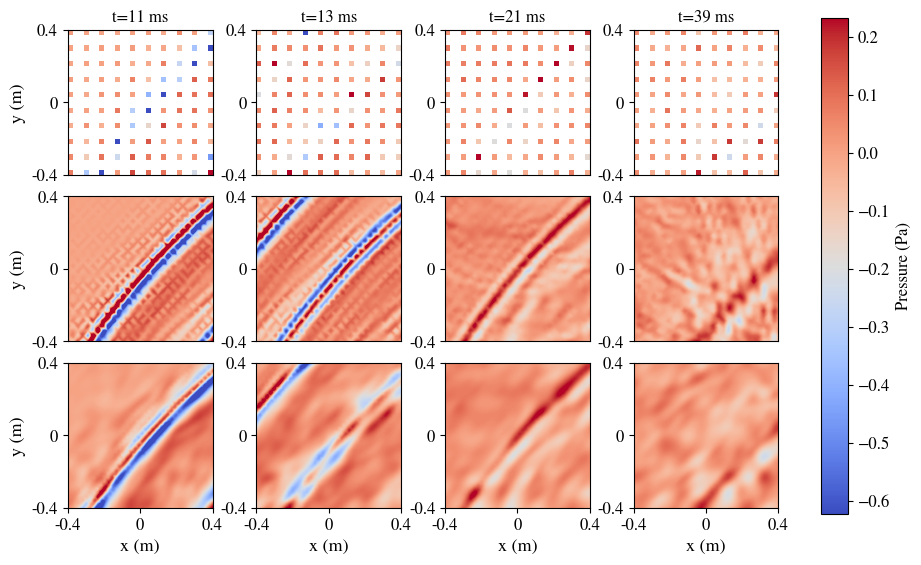

In [34]:
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(3, 4, hspace=0.15, wspace=-0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax6 = fig.add_subplot(gs[1, 0], sharey=ax1)
ax7 = fig.add_subplot(gs[1, 1], sharey=ax1)
ax8 = fig.add_subplot(gs[1, 2], sharey=ax1)
ax9 = fig.add_subplot(gs[1, 3], sharey=ax1)
ax10 = fig.add_subplot(gs[2, 0], sharey=ax1)
ax11 = fig.add_subplot(gs[2, 1], sharey=ax1)
ax12 = fig.add_subplot(gs[2, 2], sharey=ax1)
ax13 = fig.add_subplot(gs[2, 3], sharey=ax1)
# axcolorbar = fig.add_subplot(gs[:, 4])
axcolorbar = fig.add_axes([0.81, 0.1, 0.02, 0.8])
ax1, im_1 = plot_sf(p_meas_norm[:, t_ind[0]], grid_measured[0], grid_measured[1], ax=ax1, interpolated=True,
                    markersize=6, dilation=True,
                    normalise=False, clim=clims, N_interp=28)

ax1 = set_zero_in_ticks_to_int(ax1)
ax1.set_title('t={:d} ms'.format(int(t_snapshots[0] * 1000)), fontsize=12)
ax1.set_xticks([])
ax1.set_xlabel('')
# overlay measurement grid with high contrast color
ax2, im_2 = plot_sf(p_meas_norm[:, t_ind[1]], grid_measured[0], grid_measured[1], ax=ax2, interpolated=True,
                    markersize=6, dilation=True,
                    normalise=False, clim=clims, N_interp=28)
ax2 = set_zero_in_ticks_to_int(ax2)
ax2.set_xticks([])
ax2.set_title('t={:d} ms'.format(int(t_snapshots[1] * 1000)), fontsize=12)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax3, im_3 = plot_sf(p_meas_norm[:, t_ind[2]], grid_measured[0], grid_measured[1], ax=ax3, interpolated=True,
                    markersize=6, dilation=True,
                    normalise=False, clim=clims, N_interp=28)
ax3 = set_zero_in_ticks_to_int(ax3)
ax3.set_xticks([])
ax3.set_title('t={:d} ms'.format(int(t_snapshots[2] * 1000)), fontsize=12)
ax3.set_ylabel('')
ax3.set_xlabel('')
ax4, im_4 = plot_sf(p_meas_norm[:, t_ind[3]], grid_measured[0], grid_measured[1], ax=ax4, interpolated=True,
                    markersize=6, dilation=True,
                    normalise=False, clim=clims, N_interp=28)
ax4 = set_zero_in_ticks_to_int(ax4)
ax4.set_xticks([])
ax4.set_title('t={:d} ms'.format(int(t_snapshots[3] * 1000)), fontsize=12)
ax4.set_ylabel('')
ax4.set_xlabel('')
ax6, im = plot_sf(p_true_norm[:, t_ind[0]], grid[0], grid[1], ax=ax6, interpolated=True, markersize=6,
                  normalise=False, clim=clims)
ax6 = set_zero_in_ticks_to_int(ax6)
ax6.set_xlabel('')
ax6.set_xticks([])
ax7, _ = plot_sf(p_true_norm[:, t_ind[1]], grid[0], grid[1], ax=ax7, interpolated=True, markersize=6,
                 normalise=False, clim=clims)
ax7 = set_zero_in_ticks_to_int(ax7)
ax7.set_ylabel('')
ax7.set_xlabel('')
ax7.set_xticks([])
ax8, _ = plot_sf(p_true_norm[:, t_ind[2]], grid[0], grid[1], ax=ax8, interpolated=True, markersize=6,
                 normalise=False, clim=clims)
ax8 = set_zero_in_ticks_to_int(ax8)
ax8.set_ylabel('')
ax8.set_xlabel('')
ax8.set_xticks([])
ax9, _ = plot_sf(p_true_norm[:, t_ind[3]], grid[0], grid[1], ax=ax9, interpolated=True, markersize=6,
                 normalise=False, clim=clims)
ax9 = set_zero_in_ticks_to_int(ax9)
ax9.set_ylabel('')
ax9.set_xlabel('')
ax9.set_xticks([])
ax10, _ = plot_sf(p_net_norm[:, t_ind[0]], grid_dense[0], grid_dense[1], ax=ax10, interpolated=True, markersize=6,
                  normalise=False, clim=clims)
ax10 = set_zero_in_ticks_to_int(ax10)
ax11, _ = plot_sf(p_net_norm[:, t_ind[1]], grid_dense[0], grid_dense[1], ax=ax11, interpolated=True, markersize=6,
                  normalise=False, clim=clims)
ax11 = set_zero_in_ticks_to_int(ax11)
ax11.set_ylabel('')
ax12, _ = plot_sf(p_net_norm[:, t_ind[2]], grid_dense[0], grid_dense[1], ax=ax12, interpolated=True, markersize=6,
                  normalise=False, clim=clims)
ax12 = set_zero_in_ticks_to_int(ax12)
ax12.set_ylabel('')
ax13, _ = plot_sf(p_net_norm[:, t_ind[3]], grid_dense[0], grid_dense[1], ax=ax13, interpolated=True, markersize=6,
                  normalise=False, clim=clims)
ax13 = set_zero_in_ticks_to_int(ax13)
ax13.set_ylabel('')
# make all '0.0' labels an integer
axes_all = [ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

# move colorbar to the left
clb = fig.colorbar(im, cax=axcolorbar, orientation='vertical')
clb.ax.set_ylabel('Pressure (Pa)', fontsize=12)
clb.ax.tick_params(labelsize=12)
fig.show()
print('Top: Measured, Middle: Ground truth, Bottom: Prediction')

## Particle velocity snapshots

/var/folders/t0/rnh7ykvx1s372grff_qzv9l00000gn/T/ipykernel_8284/30946949.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


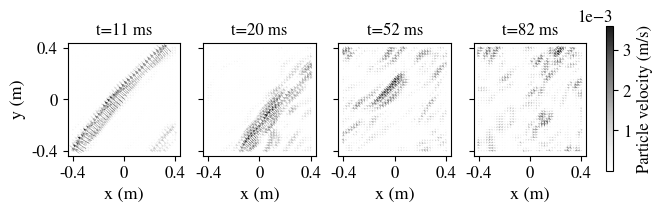

In [37]:
t = np.linspace(0, hparams.rir_time, int(hparams.rir_time * fs))
t_snapshots = [0.0115, 0.0205, 0.0528, 0.082, 0.04]
# find closest time index
t_ind = [np.argmin(np.abs(t - t_)) for t_ in t_snapshots]
dt = t[1] - t[0]
Mn = None
figsize = latex_colum_width_to_figsize(width, subplots=(2, 4))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=figsize)
figsize = (figsize[0], figsize[1])
axcolorbar = fig.add_axes([0.93, 0.15, 0.01, 0.7])
ax1, sc = plot_sf_quiver(v_net_dense[..., t_ind[0]], grid_dense[0], grid_dense[1], ax=ax1, colormax=Mn)
ax1 = set_zero_in_ticks_to_int(ax1)
ax1.set_box_aspect(1)
# set title to milliseconds from seconds
ax1.set_title('t={:d} ms'.format(int(1000 * t_snapshots[0])), fontsize=12)
ax2, _ = plot_sf_quiver(v_net_dense[..., t_ind[1]], grid_dense[0], grid_dense[1], ax=ax2, colormax=Mn)
ax2 = set_zero_in_ticks_to_int(ax2)

ax2.set_title('t={:d} ms'.format(int(1000 * t_snapshots[1])), fontsize=12)

ax2.set_ylabel('')
ax2.set_box_aspect(1)
ax3, _ = plot_sf_quiver(v_net_dense[..., t_ind[2]], grid_dense[0], grid_dense[1], ax=ax3, colormax=Mn)
ax3 = set_zero_in_ticks_to_int(ax3)
ax3.set_title('t={:d} ms'.format(int(1000 * t_snapshots[2])), fontsize=12)
ax3.set_ylabel('')
ax3.set_box_aspect(1)

ax4, _ = plot_sf_quiver(v_net_dense[..., t_ind[3]], grid_dense[0], grid_dense[1], ax=ax4, colormax=Mn)
ax4 = set_zero_in_ticks_to_int(ax4)
ax4.set_title('t={:d} ms'.format(int(1000 * t_snapshots[3])), fontsize=12)
ax4.set_ylabel('')
ax4.set_box_aspect(1)

clb = fig.colorbar(sc, cax=axcolorbar, orientation='vertical')
clb.ax.set_ylabel('Particle velocity (m/s)', fontsize=12)
clb.ax.tick_params(labelsize=12)
clb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

fig.show()


## Intensity snapshots

/var/folders/t0/rnh7ykvx1s372grff_qzv9l00000gn/T/ipykernel_8284/498873665.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


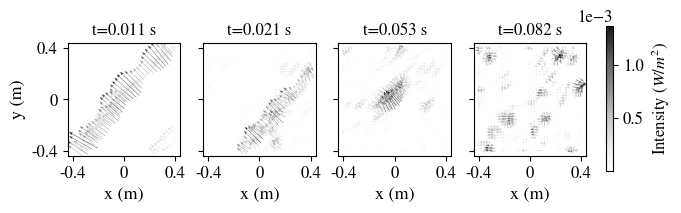

In [38]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=figsize)
figsize = (figsize[0], figsize[1])
M = None
axcolorbar = fig.add_axes([0.93, 0.15, 0.01, 0.7])
ax1, im = plot_sf_quiver(intensity_vector_dense[..., t_ind[0]], grid_dense[0], grid_dense[1], ax=ax1, colormax=M)
ax1 = set_zero_in_ticks_to_int(ax1)

ax1.set_title('t={:.3f} s'.format(t_snapshots[0]), fontsize=12)
ax2, _ = plot_sf_quiver(intensity_vector_dense[..., t_ind[1]], grid_dense[0], grid_dense[1], ax=ax2, colormax=M)
ax2 = set_zero_in_ticks_to_int(ax2)

ax2.set_title('t={:.3f} s'.format(t_snapshots[1]), fontsize=12)
ax2.set_ylabel('')
ax3, _ = plot_sf_quiver(intensity_vector_dense[..., t_ind[2]], grid_dense[0], grid_dense[1], ax=ax3, colormax=M)
ax3 = set_zero_in_ticks_to_int(ax3)

ax3.set_title('t={:.3f} s'.format(t_snapshots[2]), fontsize=12)
ax3.set_ylabel('')
ax4, _ = plot_sf_quiver(intensity_vector_dense[..., t_ind[3]], grid_dense[0], grid_dense[1], ax=ax4, colormax=M)
ax4 = set_zero_in_ticks_to_int(ax4)

ax4.set_title('t={:.3f} s'.format(t_snapshots[3]), fontsize=12)
ax4.set_ylabel('')
# set colorbar on axcolorbar
clb = fig.colorbar(im, cax=axcolorbar, orientation='vertical')
clb.ax.set_ylabel('Intensity $(W/m^2)$', fontsize=12)
clb.ax.tick_params(labelsize=12)
# # change tick format to 1e-3
clb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

fig.show()